<a href="https://colab.research.google.com/github/ajenningsfrankston/Dynamic-Memory-Network-Plus-master/blob/master/clrp_pytorch_roberta_base_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the model created in pretrain any model notebook.

1. Pretrain Roberta Model: https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
2. Finetune Roberta Model: this notebook, <br/>
   Finetune Roberta Model TPU: https://www.kaggle.com/maunish/clrp-pytorch-roberta-finetune-tpu
3. Inference Notebook: https://www.kaggle.com/maunish/clrp-pytorch-roberta-inference
4. Roberta + SVM: https://www.kaggle.com/maunish/clrp-roberta-svm

In [38]:
!pip install accelerate

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
FINAL = True

In [41]:
import os,shutil
from os import path

def move_files(source_dir,target_dir,show_dir=False):
  if not path.isdir(target_dir):
    os.makedirs(target_dir)
  #  
  file_names = os.listdir(source_dir)
  #
  for file_name in file_names:
    shutil.copy(os.path.join(source_dir, file_name), target_dir)
  #
  if show_dir:
    print(os.listdir(target_dir))
  
source_dir = '/content/gdrive/MyDrive/kaggle_datasets/commonlitreadability'
target_dir = '../input/commonlitreadabilityprize'

move_files(source_dir,target_dir,True)





['sample_submission.csv', 'train.csv', 'test.csv']


In [42]:
!pip install transformers
!pip install colorama

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from transformers import (RobertaTokenizer,RobertaModel,RobertaConfig,AutoModel,AutoTokenizer,get_cosine_schedule_with_warmup,AutoConfig)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [43]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

# exclude training data with standard error > threshold
std_error_threshold = 0.50 

print(train_data.shape[0])
train_data.head()

train_data = train_data[train_data.standard_error < std_error_threshold]

print(train_data.shape[0])
print(len(train_data))
train_data.reset_index(inplace=True)


num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

2834
1965
1965


In [44]:
config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':16,
    'valid_step':10,
    'max_len':256,
    'epochs':3,
    'nfolds':5,
    'seed':42
}

os.makedirs('models',exist_ok=True)
for i in range(config['nfolds']):
    os.makedirs(f'models/model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

In [45]:
train_data.head()

,index,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,5,f9bf357fe,NaN,NaN,Hal and Chester found ample time to take an in...,-0.861809,0.480936,5,1


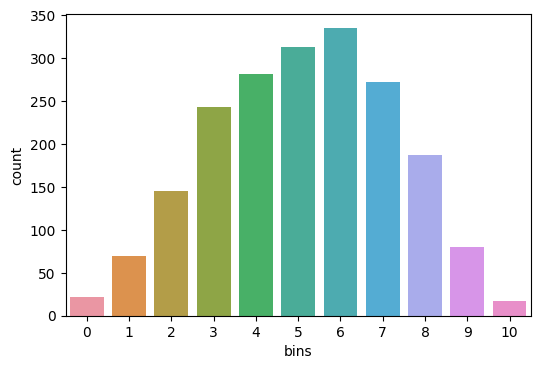

In [46]:
plt.figure(dpi=100)
sns.countplot(train_data.bins);

In [47]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer,max_len=128):
        self.excerpt = df['excerpt'].to_numpy()
        self.targets = df['target'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        target = torch.tensor(self.targets[idx],dtype=torch.float) 
        return encode, target
    
    def __len__(self):
        return len(self.excerpt)

In [48]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [49]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        config = RobertaConfig.from_pretrained("roberta-base")
        config.output_hidden_states = True

        self.roberta = RobertaModel.from_pretrained('roberta-base',config=config)  
        self.head = AttentionHead(768,768,1)
        self.dropout = nn.Dropout(0.05) #original dropout 0.1
        self.linear = nn.Linear(768,1)
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.regressor = nn.Sequential(                        
            nn.Linear(768, 1)                        
        )        

    def forward(self,**xb):
        x = self.roberta(**xb)
        last_layer_hidden_states = x.hidden_states[-2] # previously -1
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)  
        x = self.regressor(context_vector)
        return x

In [50]:
def run(fold,verbose=True):
    
    def loss_fn(outputs,targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        y = torch.sqrt(nn.MSELoss()(outputs, targets))
        return y
    
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,epoch,fold,best_loss,valid_step=10,lr_scheduler=None):
        train_loss = 0
        for i, (inputs1,targets1) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            inputs1 = {key:val.reshape(val.shape[0],-1) for key,val in inputs1.items()}
            outputs1 = model(**inputs1)
            loss1 = loss_fn(outputs1,targets1)
            loss1.backward()
            optimizer.step()
            
            train_loss += loss1.item()
            
            if lr_scheduler:
                lr_scheduler.step()
            
            #evaluating for every valid_step
            if (i % valid_step == 0) or ((i + 1) == len(train_loader)):
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for j, (inputs2,targets2) in enumerate(valid_loader):
                        inputs2 = {key:val.reshape(val.shape[0],-1) for key,val in inputs2.items()}
                        outputs2 = model(**inputs2)
                        loss2 = loss_fn(outputs2,targets2)
                        valid_loss += loss2.item()
                     
                    valid_loss /= len(valid_loader)
                    if valid_loss <= best_loss:
                        if verbose:
                            print(f"epoch:{epoch} | Train Loss:{train_loss/(i+1)} | Validation loss:{valid_loss}")
                            print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(),f'./models/model{fold}/model{fold}.bin')
                        tokenizer.save_pretrained(f'./models/model{fold}')
                        
        return best_loss
    
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    
    tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
    model = Model()

    train_ds = CLRPDataset(x_train,tokenizer,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        shuffle=True,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    valid_ds = CLRPDataset(x_valid,tokenizer,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    optimizer = optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd'])
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= 10 * len(train_dl))
    
    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = 9999
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,
                                            optimizer,epoch,fold,best_loss,
                                            valid_step=config['valid_step'],lr_scheduler=lr_scheduler)

In [51]:
for f in range(config['nfolds']):
    run(f)

cuda is used


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 0
Epoch Started:0
epoch:0 | Train Loss:0.6747504472732544 | Validation loss:0.8174585127830505
Validation loss Decreased from 9999 to 0.8174585127830505
epoch:0 | Train Loss:0.706820623441176 | Validation loss:0.6696966862678528
Validation loss Decreased from 0.8174585127830505 to 0.6696966862678528
epoch:0 | Train Loss:0.6708416910398574 | Validation loss:0.6153397679328918
Validation loss Decreased from 0.6696966862678528 to 0.6153397679328918
epoch:0 | Train Loss:0.6307716609970215 | Validation loss:0.5175793957710266
Validation loss Decreased from 0.6153397679328918 to 0.5175793957710266
epoch:0 | Train Loss:0.6025993467545977 | Validation loss:0.5056046152114868
Validation loss Decreased from 0.5175793957710266 to 0.5056046152114868
epoch:0 | Train Loss:0.5949020244059016 | Validation loss:0.4760635507106781
Validation loss Decreased from 0.5056046152114868 to 0.4760635507106781
Epoch Started:1
epoch:1 | Train Loss:0.41134544665163214 | Validation loss:0.4630174207687378
Val

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 1
Epoch Started:0
epoch:0 | Train Loss:1.7595185041427612 | Validation loss:1.1083814311027527
Validation loss Decreased from 9999 to 1.1083814311027527
epoch:0 | Train Loss:0.8245331699197943 | Validation loss:0.6859741151332855
Validation loss Decreased from 1.1083814311027527 to 0.6859741151332855
epoch:0 | Train Loss:0.7660398284594218 | Validation loss:0.6479714822769165
Validation loss Decreased from 0.6859741151332855 to 0.6479714822769165
epoch:0 | Train Loss:0.7035531718884745 | Validation loss:0.5265414357185364
Validation loss Decreased from 0.6479714822769165 to 0.5265414357185364
epoch:0 | Train Loss:0.5935809833032114 | Validation loss:0.49024665236473086
Validation loss Decreased from 0.5265414357185364 to 0.49024665236473086
epoch:0 | Train Loss:0.5799520353039542 | Validation loss:0.4872209095954895
Validation loss Decreased from 0.49024665236473086 to 0.4872209095954895
Epoch Started:1
epoch:1 | Train Loss:0.4530072401870381 | Validation loss:0.4397768211364746


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 2
Epoch Started:0
epoch:0 | Train Loss:0.837615430355072 | Validation loss:0.7670314586162568
Validation loss Decreased from 9999 to 0.7670314586162568
epoch:0 | Train Loss:0.7262432791969993 | Validation loss:0.6231097972393036
Validation loss Decreased from 0.7670314586162568 to 0.6231097972393036
epoch:0 | Train Loss:0.6741223746821994 | Validation loss:0.5069244575500488
Validation loss Decreased from 0.6231097972393036 to 0.5069244575500488
epoch:0 | Train Loss:0.5976859105796348 | Validation loss:0.4945301926136017
Validation loss Decreased from 0.5069244575500488 to 0.4945301926136017
epoch:0 | Train Loss:0.583139600323849 | Validation loss:0.460695561170578
Validation loss Decreased from 0.4945301926136017 to 0.460695561170578
epoch:0 | Train Loss:0.5675672368264534 | Validation loss:0.43791685819625853
Validation loss Decreased from 0.460695561170578 to 0.43791685819625853
epoch:0 | Train Loss:0.553010141608691 | Validation loss:0.43260751008987425
Validation loss Decrea

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 3
Epoch Started:0
epoch:0 | Train Loss:1.054263949394226 | Validation loss:0.7693528044223785
Validation loss Decreased from 9999 to 0.7693528044223785
epoch:0 | Train Loss:0.7488257397304882 | Validation loss:0.6597250115871429
Validation loss Decreased from 0.7693528044223785 to 0.6597250115871429
epoch:0 | Train Loss:0.695889874583199 | Validation loss:0.6262904191017151
Validation loss Decreased from 0.6597250115871429 to 0.6262904191017151
epoch:0 | Train Loss:0.6538841387917919 | Validation loss:0.565759916305542
Validation loss Decreased from 0.6262904191017151 to 0.565759916305542
epoch:0 | Train Loss:0.6205207705497742 | Validation loss:0.5129896128177642
Validation loss Decreased from 0.565759916305542 to 0.5129896128177642
epoch:0 | Train Loss:0.5992438255571851 | Validation loss:0.4844307351112366
Validation loss Decreased from 0.5129896128177642 to 0.4844307351112366
Epoch Started:1
epoch:1 | Train Loss:0.41073725108177433 | Validation loss:0.4751493799686432
Validat

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 4
Epoch Started:0
epoch:0 | Train Loss:0.534305214881897 | Validation loss:0.7511243033409118
Validation loss Decreased from 9999 to 0.7511243033409118
epoch:0 | Train Loss:0.6470810337500139 | Validation loss:0.6105766224861146
Validation loss Decreased from 0.7511243033409118 to 0.6105766224861146
epoch:0 | Train Loss:0.6184062717422363 | Validation loss:0.5610805964469909
Validation loss Decreased from 0.6105766224861146 to 0.5610805964469909
epoch:0 | Train Loss:0.6057065572680497 | Validation loss:0.5539156711101532
Validation loss Decreased from 0.5610805964469909 to 0.5539156711101532
epoch:0 | Train Loss:0.5691955407134822 | Validation loss:0.5222390079498291
Validation loss Decreased from 0.5539156711101532 to 0.5222390079498291
epoch:0 | Train Loss:0.5597373805415462 | Validation loss:0.5192534327507019
Validation loss Decreased from 0.5222390079498291 to 0.5192534327507019
epoch:0 | Train Loss:0.5428562390280294 | Validation loss:0.5060319375991821
Validation loss Decr

In [54]:
gdrive_model_dir = '/content/gdrive/MyDrive/kaggle_models/commonlitreadability'

if FINAL:
  shutil.make_archive(gdrive_model_dir + '/' + 'roberta_ft','zip','./models')

